# **Lectura y limpieza de datos**

### 1. Importamos las librerías que vamos a necesitar

In [1]:
import pandas as pd
import time
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

### 2. Procesamos el Data Frame de la Base de Datos de 'Estaciones'

In [2]:
# Cargamos la base de datos sin modificar y se la asignamos a un DataFrame
bdEstaciones = pd.read_csv('/kaggle/input/fuentes-energia/catalogoNacionalRaw.csv') # Datos obtenidos del IDEAM a través de Datos.gov.co
#Creamos una lista con todas las columnas que vamos eliminar del DataFrame
estacionesCdrop = ['Categoria','Nombres' 'Tecnologia', 'Estado', 'Ubicación', 'Altitud', 'Fecha_instalacion', 'Fecha_suspension', 'Area Operativa', 'Corriente', 'Area Hidrografica', 'Zona Hidrografica', 'Subzona hidrografica', 'Entidad']
# Creamos un Try para que si se corre varias veces el código, no se generen
# errores por tratar de eliminar columnas que ya no existen
try:
  bdEstaciones = bdEstaciones.drop(estacionesCdrop, axis=1)
except:
  pass

# Eliminanmos las palabras que esten despues de '(' en la columna 'Municipios'
bdEstaciones['Municipio'] = bdEstaciones['Municipio'].str.split('(').str[0]
# Eliminamos los espacios en blanco antes y después de cada dato
bdEstaciones['Municipio'] = bdEstaciones['Municipio'].str.strip()

# cambialos las vocales con tilde a vocales sin tilde en la columna 'Municipio'
bdEstaciones['Municipio'] = bdEstaciones['Municipio'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

#Elimino los espacios antes y después de cada dato
bdEstaciones.columns = bdEstaciones.columns.str.strip()

#Compruebo si existen registros Null o NaN
print(bdEstaciones[bdEstaciones.isnull().any(axis=1)])
bdEstaciones.to_csv('/kaggle/working/catalogoNacionalClean.csv')
print(bdEstaciones.head())

          Codigo                          Nombre            Categoria  \
0       52057100      RUMICHACA - AUT [52057100]         Limnigráfica   
1       52055170    LA JOSEFINA - AUT [52055170]  Climática Principal   
2       52055220     EL PARAISO - AUT [52055220]  Climática Principal   
3       44015070      EL PEPINO - AUT [44015070]  Climática Principal   
4       48015040  PUERTO NARINO - AUT [48015040]  Climática Principal   
...          ...                             ...                  ...   
8968  4401700167        NIVEL SANGOYACO GARGANTA         Limnimétrica   
8969  4401700168           NIVEL MULATO PALMERAS         Limnimétrica   
8970  4401700172           NIVEL MOCOA PISCIKART         Limnimétrica   
8971  4401700173          NIVEL RUMIYACO LAGARTO         Limnimétrica   
8972  4401700174                NIVEL RIO PEPINO         Limnimétrica   

                     Tecnologia  Estado Departamento      Municipio  \
0     Automática con Telemetría  Activa       Nariño

### 3. Procesamos el Data Frame de la Base de Datos de viento

LLamamos el archivo de nuestra nube

In [3]:
# Cargamos la base de datos sin modificar y se la asignamos a un DataFrame
bdVientosRaw = pd.read_csv('/kaggle/input/fuentes-energia/Viento.csv') # IDEAM Obtenido de Datos.gov.co

Modificamos la columna de fecha de observación pasra que tenga un formato datetime que nos permita realizar un filtrado por fechas. Se almacenan los cambios en un nuevo archivo CSV



In [4]:
# Generamos un nuevo DataFrame donde vamos a convertir los datos de la columna
# 'FechaObservacion' en el tipo datetime
bdVientosDated = bdVientosRaw.copy()
bdVientosDated['FechaObservacion'] = pd.to_datetime(bdVientosDated['FechaObservacion'])


/tmp/ipykernel_17/849869993.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  bdVientosDated['FechaObservacion'] = pd.to_datetime(bdVientosDated['FechaObservacion'])


Se filtran los datos para trabajar con las fechas  de interes seleccionadas

In [5]:
# seleccionemos los datos de FechaObservacion mayores a 2016
bdVientosDated = bdVientosDated[bdVientosDated['FechaObservacion'].dt.year >= 2016]

Seleccionamos del archivo solo las columnas que deseamos conservar

In [6]:

bdvientoFinal = bdVientosDated.iloc[:,[0,2,3,5,6,10,11]].copy()
print(bdvientoFinal.head())

   CodigoEstacion    FechaObservacion  ValorObservado Departamento Municipio  \
0        23085501 2017-12-21 00:15:00        0.000640    ANTIOQUIA   COCORNÁ   
1        27015501 2016-08-25 22:40:00        0.800000    ANTIOQUIA   YOLOMBÓ   
2        26185501 2019-07-17 01:35:00        1.317083    ANTIOQUIA    SONSÓN   
3        26185501 2016-07-21 19:55:00        1.900000    ANTIOQUIA    SONSÓN   
7        26205501 2018-10-05 05:40:00        0.903996    ANTIOQUIA   VENECIA   

           DescripcionSensor UnidadMedida  
0  Velocidad Viento (10 min)          m/s  
1  Velocidad Viento (10 min)          m/s  
2  Velocidad Viento (10 min)          m/s  
3  Velocidad Viento (10 min)          m/s  
7  Velocidad Viento (10 min)          m/s  


Agrupamos las fechas por dias, inicialmente volvemos a definir la columna fechaObservacion como tipo datetime ya que al llamarlo se pierde el tipo de dato.

In [7]:
# Convierto a formato datetime los datos de la columna FechaOservacion
bdvientoFinal['FechaObservacion'] = pd.to_datetime(bdvientoFinal['FechaObservacion'])
# Agrupo los datos de medicion de cada sensor dejando solo el valor máximo
bdvientoFinal = bdvientoFinal.groupby(['CodigoEstacion', bdvientoFinal['FechaObservacion'].dt.date,'DescripcionSensor','UnidadMedida'])['ValorObservado'].max().reset_index()

Renombramos las columnas y reindexamos para que tengan el orden que genera una mejor visibilidad de los datos

In [8]:
lColumn = ['CodigoEstacion', 'FechaObservacion', 'DescripcionSensor', 'ValorObservado','UnidadMedida']
bdvientoFinal = bdvientoFinal.reindex(columns=lColumn)
bdvientoFinal = bdvientoFinal.rename(columns={'FechaObservacion':'Fecha','DescripcionSensor':'Variable','ValorObservado':'Valor','UnidadMedida':'Unidad'})

Se procesan los datos de la columna 'Variable' para que se tenga un valor uniforme

In [9]:
# Removemos los espacios en blanco antes y después en todo el DataFrame
bdvientoFinal.columns = bdvientoFinal.columns.str.strip()
#Convertimos los datops de la columna variable en tipo str
bdvientoFinal['Variable'] = bdvientoFinal['Variable'].astype(str).str.strip()
# Damos el mismo valor a todos los datos de la columna 'Variable'
bdvientoFinal.loc[bdvientoFinal['Variable'].isin([
    'GPRS - VELOCIDAD DEL VIENTO',
    'VELOCIDAD DEL VIENTO',
    'Velocidad Viento'
]), 'Variable'] = 'Velocidad del viento'
bdvientoFinal.head()
bdvientoFinal.to_csv('/kaggle/working/vientosClean.csv')

### 4.Procesamiendo de datos de radiacion solar

In [10]:
#Cargamos todas las bases de datos de Radiación solar en DataFrames
bdrad01 = pd.read_csv('/kaggle/input/fuentes-energia/sol1.csv')
bdrad02 = pd.read_csv('/kaggle/input/fuentes-energia/sol2.csv')

In [11]:
#Concatenamos las bases de datos de radiación solar en un solo DataFrame
bdradRaw = pd.concat([bdrad01, bdrad02], ignore_index=True)
bdradRaw.head()

,CodigoEstacion,NombreEstacion,Variable,Parametro,Fecha,Unidad,Valor,NivelAprobacion
0,26255030,SANTA ISABEL VALDIVIA [26255030],RAD SOLAR,Radiación solar global horaria VALIDADA,2010-01-01 01:00,Wh/m^2,0.0,Definitivo
1,26255030,SANTA ISABEL VALDIVIA [26255030],RAD SOLAR,Radiación solar global horaria VALIDADA,2010-01-01 02:00,Wh/m^2,0.0,Definitivo
2,26255030,SANTA ISABEL VALDIVIA [26255030],RAD SOLAR,Radiación solar global horaria VALIDADA,2010-01-01 03:00,Wh/m^2,0.0,Definitivo
3,26255030,SANTA ISABEL VALDIVIA [26255030],RAD SOLAR,Radiación solar global horaria VALIDADA,2010-01-01 04:00,Wh/m^2,0.0,Definitivo
4,26255030,SANTA ISABEL VALDIVIA [26255030],RAD SOLAR,Radiación solar global horaria VALIDADA,2010-01-01 05:00,Wh/m^2,0.0,Definitivo


In [12]:
# Selecciono las columnas que deseo conservar
solClean = bdradRaw.loc[:,['CodigoEstacion','Fecha', 'Variable','Unidad', 'Valor']]

#intercambio el orden de las columnas unidad y valor
solClean = solClean[['CodigoEstacion','Fecha', 'Variable','Valor','Unidad']]
solClean['Fecha'] = pd.to_datetime(solClean['Fecha'])
solClean.to_csv('/kaggle/working/solClean.csv')
solClean.head()



,CodigoEstacion,Fecha,Variable,Valor,Unidad
0,26255030,2010-01-01 01:00:00,RAD SOLAR,0.0,Wh/m^2
1,26255030,2010-01-01 02:00:00,RAD SOLAR,0.0,Wh/m^2
2,26255030,2010-01-01 03:00:00,RAD SOLAR,0.0,Wh/m^2
3,26255030,2010-01-01 04:00:00,RAD SOLAR,0.0,Wh/m^2
4,26255030,2010-01-01 05:00:00,RAD SOLAR,0.0,Wh/m^2


### 5. Procesamiento base de datos de caudal

In [13]:
# Cargo todos los datos de Caudal en DataFrames
caudal0 = pd.read_csv('/kaggle/input/fuentes-energia/descargaDhime.csv')
caudal1= pd.read_csv('/kaggle/input/fuentes-energia/descargaDhime (1).csv')
caudal2= pd.read_csv('/kaggle/input/fuentes-energia/descargaDhime (2).csv')
caudal3= pd.read_csv('/kaggle/input/fuentes-energia/descargaDhime (3).csv')
caudal4= pd.read_csv('/kaggle/input/fuentes-energia/descargaDhime (4).csv')
# Concateno todos los DataFrame de caudal en un solo DataFrame
bdCaudal = pd.concat([caudal0, caudal1, caudal2, caudal3, caudal4], ignore_index=True)

In [14]:
# Selecciono las columnas que deso conservar y los almaceno en un Data Frame
# nuevo
bdCaudalClean = bdCaudal.loc[:,['CodigoEstacion','Fecha', 'Variable','Valor','Unidad']]
# Coinviertolos datos de la columna 'Fecha' al tipo datetime
bdCaudalClean['Fecha'] = pd.to_datetime(bdCaudalClean['Fecha'])
# Guardo los datos limpios en un archivo CSV
bdCaudalClean.to_csv('/kaggle/working/CaudalClean.csv')
bdCaudalClean.head()

,CodigoEstacion,Fecha,Variable,Valor,Unidad
0,26247030,2016-01-02,CAUDAL,360.4650,m^3/s
1,26247030,2016-01-03,CAUDAL,256.4800,m^3/s
2,26247030,2016-01-04,CAUDAL,315.4300,m^3/s
3,26247030,2016-01-05,CAUDAL,281.2330,m^3/s
4,26247030,2016-01-06,CAUDAL,339.1045,m^3/s


# **Procesamiento de los datos**

### 6. agrupamos las tablas de datos

In [15]:
bdDatosClean = pd.concat([bdCaudalClean, solClean, bdvientoFinal], ignore_index=True)
bdDatosClean

,CodigoEstacion,Fecha,Variable,Valor,Unidad
0,26247030,2016-01-02 00:00:00,CAUDAL,360.4650,m^3/s
1,26247030,2016-01-03 00:00:00,CAUDAL,256.4800,m^3/s
2,26247030,2016-01-04 00:00:00,CAUDAL,315.4300,m^3/s
3,26247030,2016-01-05 00:00:00,CAUDAL,281.2330,m^3/s
4,26247030,2016-01-06 00:00:00,CAUDAL,339.1045,m^3/s
...,...,...,...,...,...
448668,2702500107,2025-01-28,Velocidad del viento,4.3000,m/s
448669,2702500107,2025-01-29,Velocidad del viento,3.6000,m/s
448670,2702500107,2025-01-30,Velocidad del viento,4.7000,m/s
448671,2702500107,2025-01-31,Velocidad del viento,1.8000,m/s


### 7. Unimos los datos con la tabla de estaciones y le damos la forma final

In [16]:
#Agrupo la tabla cataloNacionalClean con bdDatosClean con llave primaria Codigo y foranea CodigoEstacion
bdDatosFinal = pd.merge(bdDatosClean, bdEstaciones, left_on='CodigoEstacion', right_on='Codigo')

# Eliminamos la columna 'CodigoEstacion'
bdDatosFinal.drop(columns=['CodigoEstacion', 'Nombre'], inplace=True)

# Reordenamos las columnas para que 'Codigo' sea la primera
columnas_ordenadas = ['Codigo'] + [col for col in bdDatosFinal.columns if col != 'Codigo']
bdDatosFinal = bdDatosFinal[columnas_ordenadas]

# Guardamos la el DataFrame en un CSV
bdDatosFinal.to_csv('/kaggle/working/datosFinalClean.csv')

# **Visualización de los datos**

### 8. Creo una gráfica por cada tipo de sensor

In [17]:
bdDatosFinal = pd.read_csv('/kaggle/working/datosFinalClean.csv')
# Imprimo los valores únicos de la columna Fecha
print(bdDatosFinal['Fecha'].unique())

/tmp/ipykernel_17/132457578.py:1: DtypeWarning: Columns (14,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bdDatosFinal = pd.read_csv('/kaggle/working/datosFinalClean.csv')


['2016-01-02 00:00:00' '2016-01-03 00:00:00' '2016-01-04 00:00:00' ...
 '2022-03-28' '2022-03-29' '2022-03-30']


/tmp/ipykernel_17/216592104.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  caudal_df['Año'] = caudal_df['Fecha'].dt.year


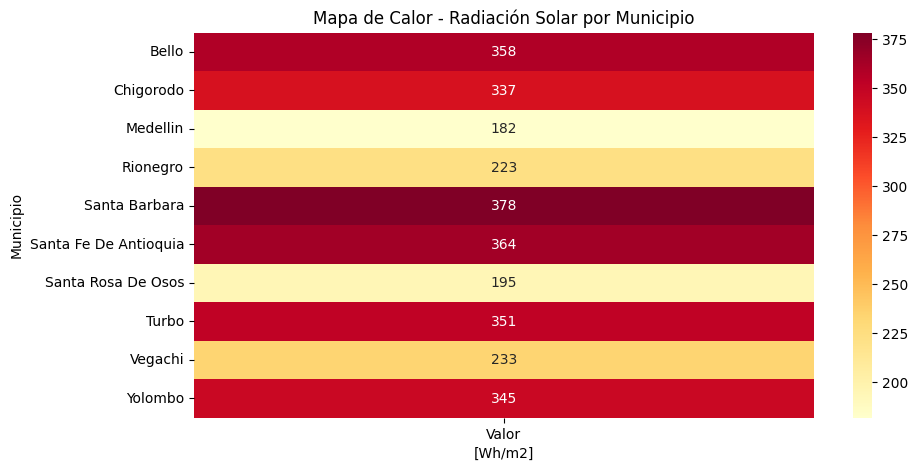

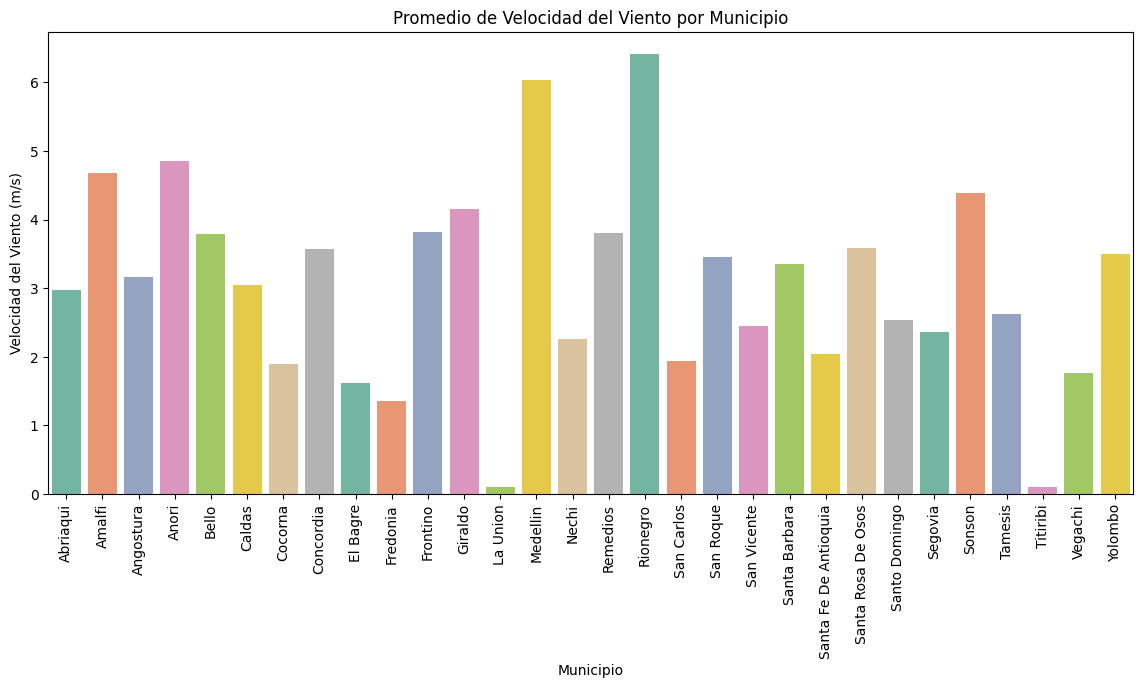

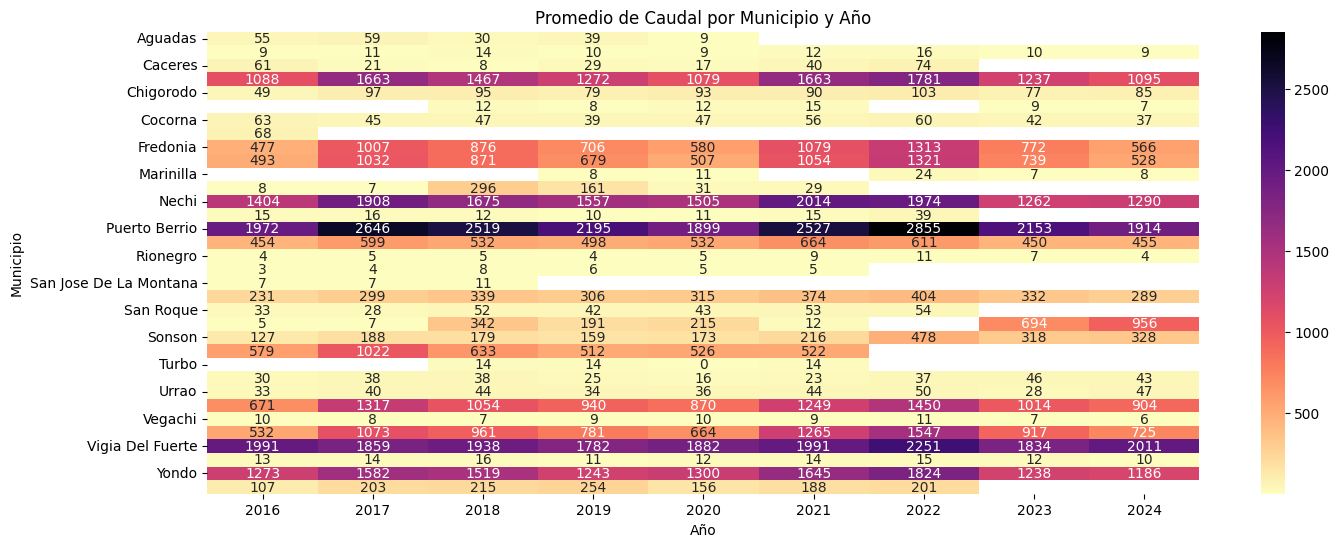

In [18]:
# Convertir 'Fecha' a tipo datetime sin incluir hh:mm:ss
bdDatosFinal['Fecha'] = pd.to_datetime(bdDatosFinal['Fecha'], format='mixed', errors='coerce')


# --- Calcular promedio de Velocidad del Viento por Código y Día ---
viento_df = bdDatosFinal[bdDatosFinal['Variable'] == 'Velocidad del viento']
viento_avg = viento_df.groupby(['Codigo', bdDatosFinal['Fecha'].dt.date])['Valor'].mean().reset_index()
viento_avg.rename(columns={'Fecha': 'FechaDia', 'Valor': 'PromedioVelocidad'}, inplace=True)

# --- Calcular promedio de Caudal por Municipio y Año ---
caudal_df = bdDatosFinal[bdDatosFinal['Variable'] == 'CAUDAL']
caudal_df['Año'] = caudal_df['Fecha'].dt.year
caudal_avg = caudal_df.groupby(['Municipio', 'Año'])['Valor'].mean().reset_index()

# --- 1. Gráfico Heatmap para Radiación Solar ---
solar_df = bdDatosFinal[bdDatosFinal['Variable'] == 'RAD SOLAR'].groupby('Municipio')['Valor'].mean().reset_index()
plt.figure(figsize=(10, 5))
sns.heatmap(solar_df.pivot_table(index='Municipio', values='Valor'), cmap='YlOrRd', annot=True, fmt='.0f')
plt.xlabel('[Wh/m2]')
plt.title("Mapa de Calor - Radiación Solar por Municipio")
plt.show()

# --- 2. Boxplot para Velocidad del Viento ---
viento_municipios = viento_df.groupby('Municipio')['Valor'].mean().reset_index()
plt.figure(figsize=(14, 6))
sns.barplot(x='Municipio', y='Valor', data=viento_municipios, palette='Set2', hue='Municipio')
plt.xticks(rotation=90)
plt.ylabel("Velocidad del Viento (m/s)")
plt.xlabel("Municipio")
plt.title("Promedio de Velocidad del Viento por Municipio")
plt.show()

# --- 3. Gráfico Heatmap para Caudal por Municipio y Año ---
if not caudal_avg.empty and 'Municipio' in caudal_avg.columns and 'Año' in caudal_avg.columns:
    pivot_caudal = caudal_avg.pivot(index='Municipio', columns='Año', values='Valor')
    plt.figure(figsize=(16, 6))
    sns.heatmap(pivot_caudal, cmap='magma_r', annot=True, fmt='.0f')
    plt.ylabel("Municipio")
    plt.xlabel("Año")
    plt.title("Promedio de Caudal por Municipio y Año")
    plt.show()
else:
    print("No hay datos suficientes o hay un problema con las columnas para generar el heatmap de Caudal.")


